<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

**Special thanks** to Lina Yang and Danielle Fong for supplying much of the code for this solution. Problem explanations courtesy of Nicholas Beaudoin.

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Ames housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# added some formatting for EDA
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['font.size'] = 11
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
data=pd.read_csv('../data/AmesHousing.csv')# Import Ames housing data

In [3]:
data.head(5)# Look at first 5 rows

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
data.shape# identify the dimension. there are 82 feature columns and 2930 index rows.

(2930, 82)

In [7]:
data.dtypes.head(5)
          
# identify all of the data types from the Ames data.

Order             int64
PID               int64
MS SubClass       int64
MS Zoning        object
Lot Frontage    float64
dtype: object

In [8]:
ames=data.loc[data.Neighborhood == 'NAmes']# identify the index of the Ames data

In [9]:
ames.head(10)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
23,24,527402200,20,RL,NaN,11241,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1970,1970,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,ALQ,578.0,Unf,0.0,426.0,1004.0,GasA,Ex,Y,SBrkr,1004,0,0,1004,1.0,0.0,1,0,2,1,TA,5,Typ,1,TA,Attchd,1970.0,Fin,2.0,480.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,Shed,700,3,2010,WD,Normal,149000
24,25,527402250,20,RL,NaN,12537,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1971,2008,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,GLQ,734.0,Unf,0.0,344.0,1078.0,GasA,Ex,Y,SBrkr,1078,0,0,1078,1.0,0.0,1,1,3,1,TA,6,Typ,1,Fa,Attchd,1971.0,Fin,2.0,500.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,149900
25,26,527403020,20,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1968,1968,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,775.0,Unf,0.0,281.0,1056.0,GasA,Ex,Y,SBrkr,1056,0,0,1056,1.0,0.0,1,0,3,1,TA,6,Typ,1,Fa,Attchd,1968.0,Unf,1.0,304.0,TA,TA,Y,0,85,184,0,0,0,NaN,NaN,NaN,0,7,2010,WD,Normal,142000
26,27,527404120,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,804.0,Rec,78.0,0.0,882.0,GasA,TA,Y,SBrkr,882,0,0,882,1.0,0.0,1,0,2,1,TA,4,Typ,0,NaN,Attchd,1970.0,Fin,2.0,525.0,TA,TA,Y,240,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal,126000
27,28,527425090,20,RL,70.0,10500,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1971,1971,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,432.0,Unf,0.0,432.0,864.0,GasA,TA,Y,SBrkr,864,0,0,864,0.0,0.0,1,0,3

### 1. Clean Up Data and Perform Exporatory Data Analysis

Select about 3-4 continuous features and also the target variable "SalesPrice"

In [10]:
ames.columns.values# identify header rows of your data subset

array(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage',
       'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood',
       'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
       'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
       'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
       'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',

In [12]:
ames.isnull().sum().head(5)# check to see if there are any nulls in each of the datasets. it looks like there are zero nulls

Order            0
PID              0
MS SubClass      0
MS Zoning        0
Lot Frontage    68
dtype: int64

In [13]:
data.isnull().sum().head(5)

Order             0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage    490
dtype: int64

In [14]:
ames.isnull().sum()/ames.shape[0]# look at percent nulls

Order              0.000000
PID                0.000000
MS SubClass        0.000000
MS Zoning          0.000000
Lot Frontage       0.153499
Lot Area           0.000000
Street             0.000000
Alley              0.993228
Lot Shape          0.000000
Land Contour       0.000000
Utilities          0.000000
Lot Config         0.000000
Land Slope         0.000000
Neighborhood       0.000000
Condition 1        0.000000
Condition 2        0.000000
Bldg Type          0.000000
House Style        0.000000
Overall Qual       0.000000
Overall Cond       0.000000
Year Built         0.000000
Year Remod/Add     0.000000
Roof Style         0.000000
Roof Matl          0.000000
Exterior 1st       0.000000
Exterior 2nd       0.000000
Mas Vnr Type       0.000000
Mas Vnr Area       0.000000
Exter Qual         0.000000
Exter Cond         0.000000
Foundation         0.000000
Bsmt Qual          0.038375
Bsmt Cond          0.038375
Bsmt Exposure      0.038375
BsmtFin Type 1     0.038375
BsmtFin SF 1       0

In [ ]:
medianlist=ames.median()

In [ ]:
medianlist.head(5)

In [ ]:
type(medianlist)

In [31]:
nonulls_ames=ames.fillna(0)
    
#fill na with median values

#filled all with 0, since the features I chose have no nulls

In [32]:
nonulls_ames.head()# Sanity check

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,0,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,0,MnPrv,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,0,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,0,0,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,0,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,0,0,0,0,4,2010,WD,Normal,244000
23,24,527402200,20,RL,0.0,11241,Pave,0,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1970,1970,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,ALQ,578.0,Unf,0.0,426.0,1004.0,GasA,Ex,Y,SBrkr,1004,0,0,1004,1.0,0.0,1,0,2,1,TA,5,Typ,1,TA,Attchd,1970.0,Fin,2.0,480.0,TA,TA,Y,0,0,0,0,0,0,0,0,Shed,700,3,2010,WD,Normal,149000


In [18]:
# identify the number of unique values for each column
ames.nunique().head(5)

Order           443
PID             443
MS SubClass      13
MS Zoning         2
Lot Frontage     61
dtype: int64

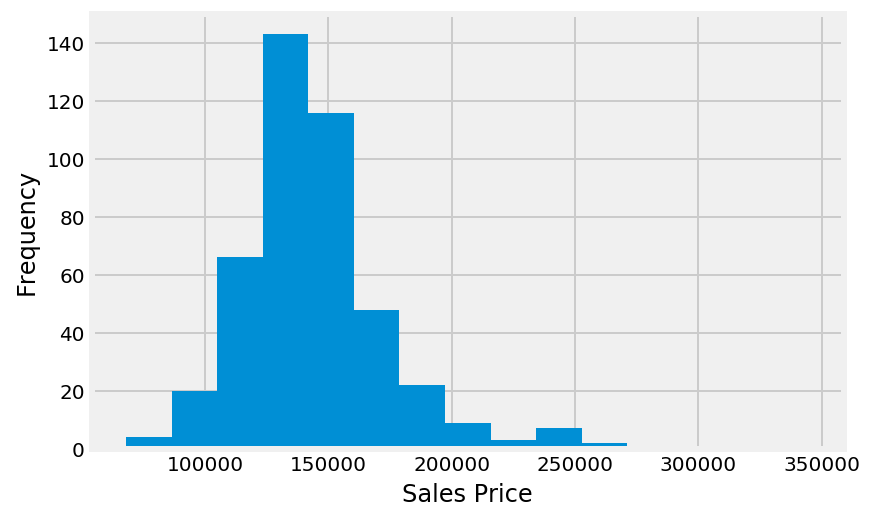

In [19]:
# plot the distribution of the target variable SalePrice. 
ames["SalePrice"].plot.hist(bins=15);

plt.xlabel('Sales Price');


In [ ]:
# Describe the distribution

#this distribution is skewed right with a high positive kurtosis.

In [22]:
# visualize Pearson scores
import scipy.stats as ss
X1=ames['Full Bath'].values
X2=ames['Lot Area'].values
X3=ames['Year Remod/Add'].values
y=ames.SalePrice.values
pear1=ss.pearsonr(X1,y)
pear2=ss.pearsonr(X2,y)
pear3=ss.pearsonr(X3,y)
pear_list=[pear1,pear2,pear3]

In [23]:
print(pear1)
print(pear2)
print(pear3)

(0.3927129601694112, 8.710552017155949e-18)
(0.48791143382349006, 7.1102784047003595e-28)
(0.33261521313760867, 6.642857112479712e-13)


In [ ]:
# Describe what you see

#lot area is the most correlated with sales price, while full bath and year remodeled are less correlated and almost
#equal. since the pearson coefficient for lot area is almost .5, we can conclude they are slightly
#correlated


## 2. Using `scikit-learn` Linear Regression

Score and plot your predictions. What do these results tell us?

In [33]:
numcols=nonulls_ames._get_numeric_data()

In [34]:
numcols.columns

Index(['Order', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area',
       'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch',
       'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold',
       'SalePrice'],
      dtype='object')

In [35]:
feature_cols=['Full Bath','Lot Area','Year Remod/Add']

In [36]:
from sklearn.linear_model import LinearRegression
X = numcols[feature_cols]
y = numcols.SalePrice

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

-847938.6244363913
[2.04789194e+04 4.07261759e+00 4.70449608e+02]


In [37]:
list(zip(feature_cols, linreg.coef_))

[('Full Bath', 20478.919390487325),
 ('Lot Area', 4.072617585598064),
 ('Year Remod/Add', 470.4496078613862)]

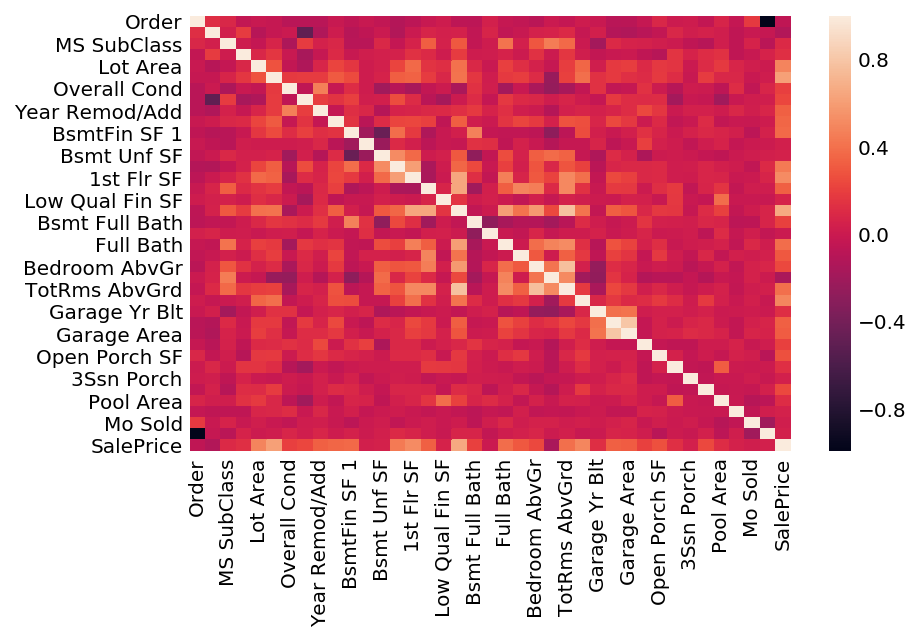

In [38]:
# create feature matrix. based on the correlation matrix it looks like 'RM' and 'LSAT' have the highest correlation to the target variable.
sns.heatmap(nonulls_ames.corr())

[0.01870271 0.63494659 0.3463507 ]


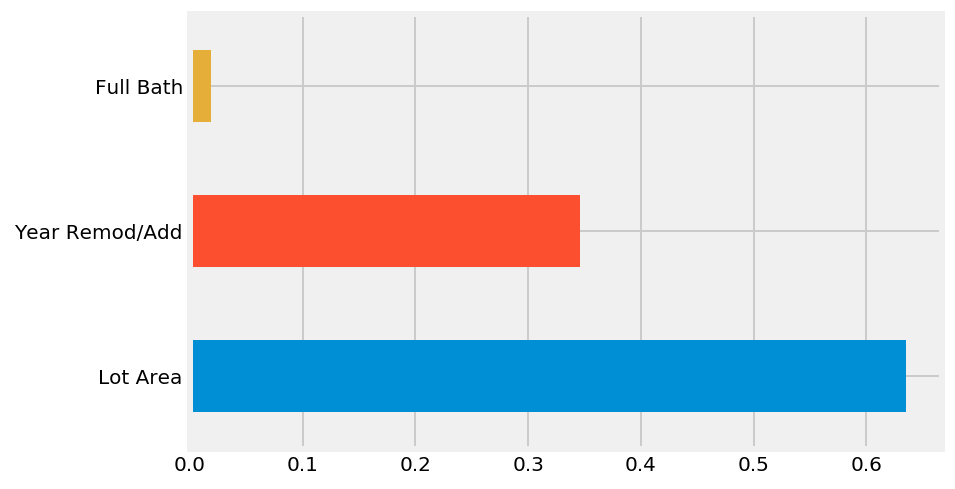

In [41]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
# fit linear regression model on feature matrix and y

In [42]:
numcols.head(5)

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
0,1,526301100,20,141.0,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,1960.0,2.0,528.0,210,62,0,0,0,0,0,5,2010,215000
1,2,526350040,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,105000
2,3,526351010,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010,172000
3,4,526353030,20,93.0,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,1968.0,2.0,522.0,0,0,0,0,0,0,0,4,2010,244000
23,24,527402200,20,0.0,11241,6,7,1970,1970,180.0,578.0,0.0,426.0,1004.0,1004,0,0,1004,1.0,0.0,1,0,2,1,5,1,1970.0,2.0,480.0,0,0,0,0,0,0,700,3,2010,149000


In [43]:
numcols['preds']=linreg.coef_[0]*numcols['Full Bath']+linreg.coef_[1]*numcols['Lot Area']+linreg.coef_[2]*numcols['Year Remod/Add']+linreg.intercept_

In [44]:
numcols.head(5)

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,preds
0,1,526301100,20,141.0,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,1960.0,2.0,528.0,210,62,0,0,0,0,0,5,2010,215000,224008.587057
1,2,526350040,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,105000,142423.937550
2,3,526351010,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010,172000,151784.662240
3,4,526353030,20,93.0,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,1968.0,2.0,522.0,0,0,0,0,0,0,0,4,2010,244000,164314.454871
23,24,527402200,20,0.0,11241,6,7,1970,1970,180.0,578.0,0.0,426.0,1004.0,1004,0,0,1004,1.0,0.0,1,0,2,1,5,1,1970.0,2.0,480.0,0,0,0,0,0,0,700,3,2010,149000,145106.316721


In [45]:
pred_val = numcols['preds']
true_val = numcols['SalePrice']
numcols['res'] = true_val - pred_val

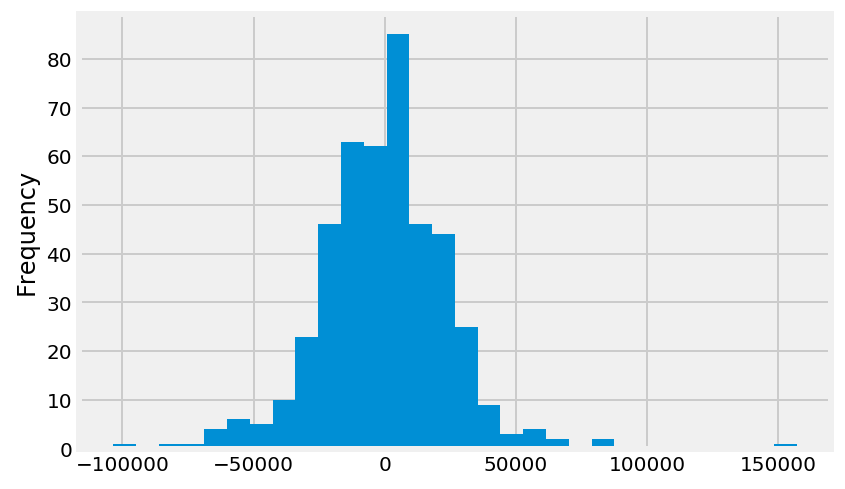

In [46]:
numcols['res'].plot(kind='hist',bins=30)

In [49]:
# predict y based on the model

# display predictor coefficients

# R2 score of the model
from sklearn.metrics import r2_score
from sklearn import metrics

coefficient_of_dermination = r2_score(true_val, pred_val)
print(coefficient_of_dermination)
print(metrics.mean_absolute_error(true_val, pred_val))

0.3978626972161423
18240.06402850778


The scoring indicates that this model accounts for about 52% of the variability around the mean. Good to start with but will have to look for ways to increase the model's performance.

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [55]:
# print 70/30 train/test split results
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
linreg1 = LinearRegression()
linreg1.fit(X_train, y_train)
y_pred1 = linreg.predict(X_test)
(y_test - y_pred1).head()
print(metrics.mean_absolute_error(y_test, y_pred1))

19609.205295799147


In [56]:
# 90/10 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
linreg2 = LinearRegression()
linreg2.fit(X_train, y_train)
y_pred2 = linreg.predict(X_test)
(y_test - y_pred2).head()
print(metrics.mean_absolute_error(y_test, y_pred2))

17366.439372624875


### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [57]:
# import model_selection from sklearn
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [58]:

# iterate through folds 5-10
for folds in range(5,11):
    print('K: {}'.format(folds))
    model = LinearRegression()
    
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=folds)
    print("Cross-validated scores: {}".format(scores))
    print("Mean CV R2: {}".format(np.mean(scores)))
    print('Std CV R2: {}'.format(np.std(scores)))
    
    # Make cross-validated predictions
    predictions = cross_val_predict(model, X, y, cv=folds)
    
    r2 = metrics.r2_score(y, predictions)
    print("Cross-Predicted R2: {}".format(r2))

    

K: 5
Cross-validated scores: [0.26978254 0.2956635  0.41522258 0.53323917 0.46174761]
Mean CV R2: 0.39513107900381056
Std CV R2: 0.09952017582635463
Cross-Predicted R2: 0.38742251439671016
K: 6
Cross-validated scores: [0.271223   0.20773309 0.44237304 0.30671445 0.6046997  0.48481026]
Mean CV R2: 0.3862589257097116
Std CV R2: 0.13663186096938496
Cross-Predicted R2: 0.3843624039690978
K: 7
Cross-validated scores: [0.23282394 0.25476699 0.33479178 0.47758176 0.03506493 0.63760798
 0.49964466]
Mean CV R2: 0.35318314895109854
Std CV R2: 0.18652192479917934
Cross-Predicted R2: 0.38361698205304906
K: 8
Cross-validated scores: [0.20071818 0.26869369 0.31173745 0.46946134 0.3996866  0.45568171
 0.49691527 0.52952016]
Mean CV R2: 0.39155179969498477
Std CV R2: 0.1108305934040827
Cross-Predicted R2: 0.3872107592787669
K: 9
Cross-validated scores: [0.22471252 0.25872178 0.27353611 0.4121871  0.46689249 0.04184804
 0.59042313 0.61031684 0.42898874]
Mean CV R2: 0.36751408217653064
Std CV R2: 0.1736

We find that k=6 has the lowest variance from a low standard deviation in the R2. But k=5 has a higher average r2 than k=6, which is 0.51. As always, there is a tradeoff between bias (error) and variance. The optimal solution appears to be k=5 (both mean R2 and std R2, bias and variance) are low.

# KNN Practice

In [59]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [60]:
iris.head()

# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

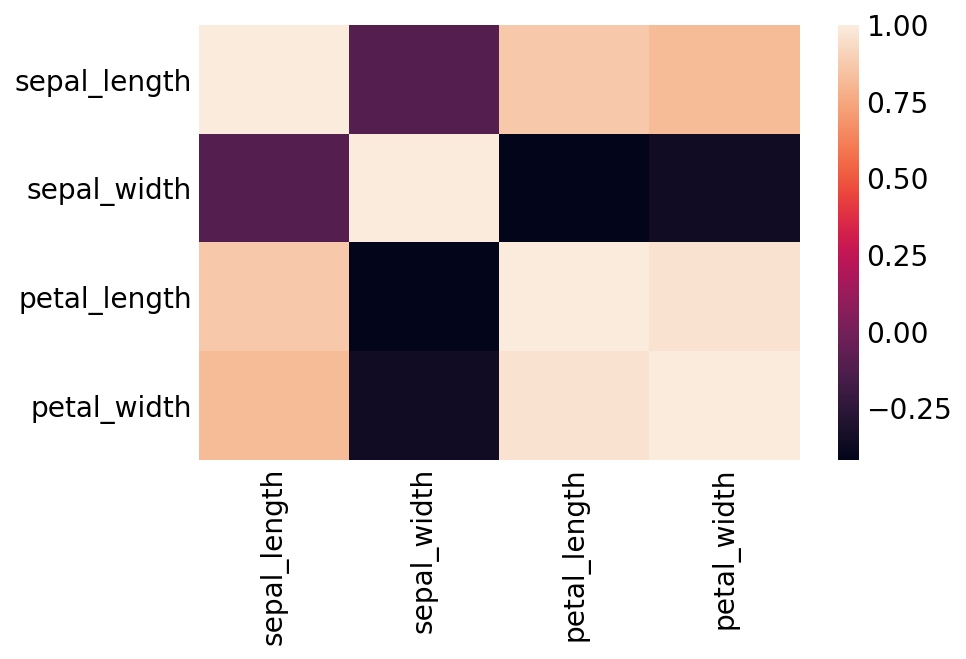

In [61]:
# Create a custom colormap
sns.heatmap(iris.corr());

In [62]:
#see the first five rows of the data to know what you are working with
iris.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [63]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'
iris['species_num'] = iris['species'].apply(lambda x: 1 if x == 'Iris-versicolor' else (0 if x == 'Iris-setosa' else 2))

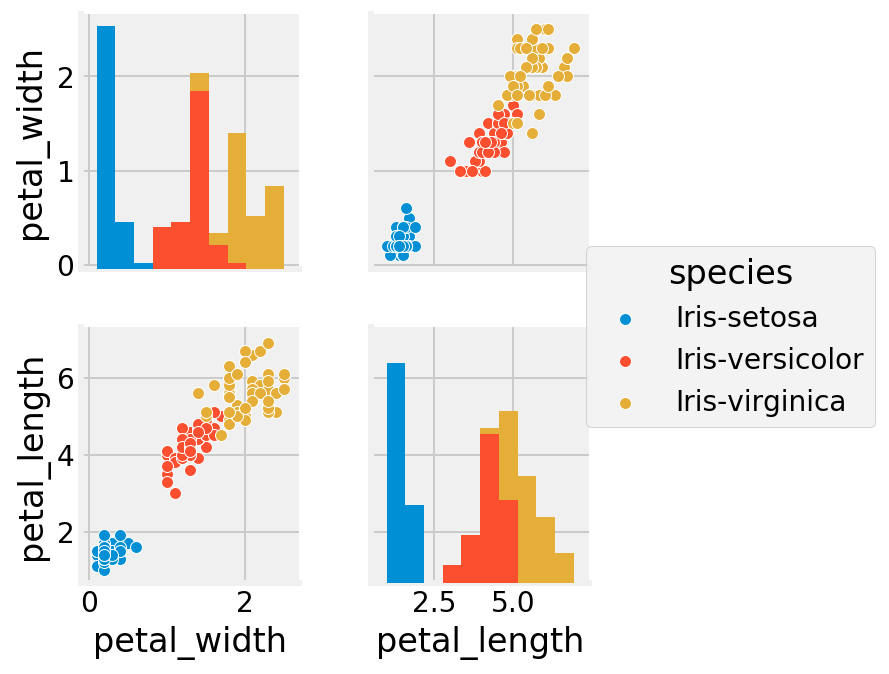

In [64]:
# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
sns.pairplot(iris, hue="species",vars=["petal_width", "petal_length"])

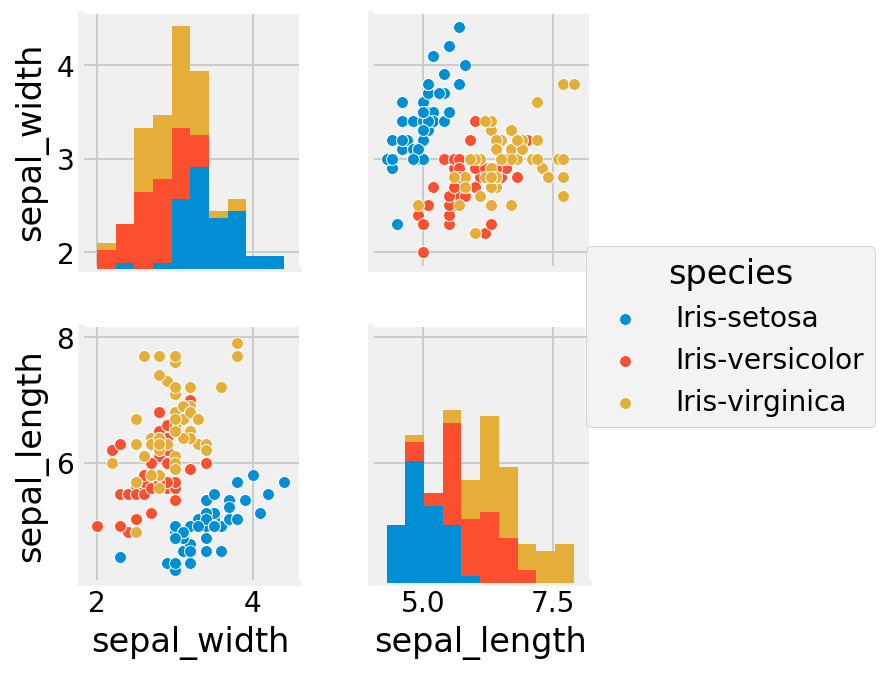

In [65]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
sns.pairplot(iris, hue="species",vars=["sepal_width", "sepal_length"])

A first glance analysis demonstrates that "petal_width" is the best predictor.

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [66]:
# create feature matrix
feature_cols=['sepal_length','sepal_width','petal_width','petal_length']
X=iris[feature_cols]


### Create your target vector "y"
This will be the species type.

In [67]:
y=iris.species_num

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [69]:
from sklearn.neighbors import KNeighborsClassifier

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [70]:
# use train test split on the data at 75/25 split.

# instantiate model
KN=KNeighborsClassifier(n_neighbors=1)
# fit model with X_train and y_train
KN.fit(X_train,y_train)

# predict y from the X test data
y_pred_numtype = KN.predict(X_test)
y_pred_numtype

# score the model 
metrics.accuracy_score(y_test, y_pred_numtype)

0.9210526315789473

In [79]:
# use train test split on the data at 75/25 split.

# instantiate model
KN0=KNeighborsClassifier(n_neighbors=1)
# fit model with X_train and y_train
KN0.fit(X,y)

# predict y from the X test data
y_pred_numtype_0 = KN0.predict(X)
y_pred_numtype_0

# score the model 
metrics.accuracy_score(y, y_pred_numtype_0)

##this is a test to show that using the full set of data shows perfect results

1.0

Perfect score, that seems odd, right? Well, if you remember from our lesson on KNN, when the number of neighbors is equal to 1, then it will choose itself each time. Thus, a perfect score, or a score very near perfect as we will see after we try this again with shuffled data.

### Create a Model With Five Neighbors. Did it Improve?

In [71]:
# make an instance with 5 neighbors
KN5=KNeighborsClassifier(n_neighbors=5)
# train test split

# fit model with X_train and y_train
KN5.fit(X_train,y_train)
#predict y from the X test data
y_pred_numtype_5 = KN5.predict(X_test)
y_pred_numtype_5
#score the model
metrics.accuracy_score(y_test, y_pred_numtype_5)

0.9210526315789473

In [ ]:
#increasing from 1 to 5 NN did not improve accuracy

This looks better. Now, we still have issues with the Iris dataset because the first 50 observations are one species of flower, followed by 50 of the next, and then 50 of the third type. We will need to use a shuffle the dataset when we bring it in next time. Let's try that now.

In [72]:
from sklearn.utils import shuffle
iris_sh=shuffle(iris)
# Create X and y
X_sh=iris_sh[feature_cols]
y_sh=iris_sh.species_num
X_train_sh, X_test_sh, y_train_sh, y_test_sh = train_test_split(X_sh, y_sh, random_state=99)



Rerun n_neighbors=1 with shuffled data

In [77]:
# instantiate model
KN_sh=KNeighborsClassifier(n_neighbors=1)
# fit model with X_train and y_train
KN_sh.fit(X_train_sh,y_train_sh)

# predict y from the X test data
y_pred_numtype_sh = KN_sh.predict(X_test_sh)
y_pred_numtype_sh

# score the model 
metrics.accuracy_score(y_test_sh, y_pred_numtype_sh)

0.9736842105263158

Rerun n_neighbors=5 with shuffled data

In [78]:
# instantiate model
KN_sh=KNeighborsClassifier(n_neighbors=5)
# fit model with X_train and y_train
KN_sh.fit(X_train_sh,y_train_sh)

# predict y from the X test data
y_pred_numtype_sh = KN_sh.predict(X_test_sh)
y_pred_numtype_sh

# score the model 
metrics.accuracy_score(y_test_sh, y_pred_numtype_sh)

1.0

In [ ]:
#when shuffled, accuracy got better with k=5 (overall accuracy increased in both scenarios)

### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [75]:
# create list to store results
scores = []

# loop through 100 models
for k in range(1,100):
    # Instantiate
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit
    knn.fit(X,y)
    
    # Predict
    pred = knn.predict(X)
    
    # Score
    score = float(sum(pred == y)) / len(y)
    
    #Append results
    scores.append([k, score])

In [76]:
scores[0:20]

[[1, 1.0],
 [2, 0.98],
 [3, 0.96],
 [4, 0.96],
 [5, 0.9666666666666667],
 [6, 0.9733333333333334],
 [7, 0.9733333333333334],
 [8, 0.98],
 [9, 0.98],
 [10, 0.98],
 [11, 0.9733333333333334],
 [12, 0.98],
 [13, 0.98],
 [14, 0.98],
 [15, 0.9866666666666667],
 [16, 0.9866666666666667],
 [17, 0.98],
 [18, 0.9733333333333334],
 [19, 0.98],
 [20, 0.98]]

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?